In [1]:
# Initial imports
import pandas as pd
import numpy as np
from pathlib import Path
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, classification_report
from pandas.tseries.offsets import DateOffset
import plotly.express as px
import plotly.graph_objects as go
import plotly.io as pio
from datetime import datetime, timedelta

# Needed for decision tree visualization
import pydotplus
from IPython.display import Image

pd.set_option('mode.chained_assignment', None)

In [2]:
# User Inputs

# Asset List
assetNames = ['crudeOil', 'Gold', 'Russel2000', 'S&P500', 'EUR-USD', 'GBP-JPY', 'BTC-USD', 'ETH-USD']


# Portfolio Metrics
initial = 10000
riskFree = 0.01

# Random Forest Hyperparameters
estimators = 500

In [3]:
# raw Features
rawFeatures = ['EMAShort', 'EMALong',  'RSIline', 'MOMline', 'ROCline','SMAline', 'lowerBB_zscore', 'middleBB',
               "upperBB", "2stdBB", "MACDline", 'MACDHistogram','MACDSignal']


# z-scores Features
zScoreFeatures = ['EMAShort_zscore', 'EMALong_zscore',  'RSIline_zscore', 'MOMline_zscore', 'ROCline_zscore',
                   'SMAline_zscore', 'lowerBB_zscore', 'middleBB_zscore', "upperBB_zscore", 
                  "2stdBB_zscore", "MACDline_zscore", 'MACDHistogram_zscore','MACDSignal_zscore' ]


# normal Features
normalFeatures = ['EMAShort_normal', 'EMALong_normal',  'RSIline_normal', 'MOMline_normal', 'ROCline_normal',
                   'SMAline_normal', 'lowerBB_normal', 'middleBB_normal', "upperBB_normal", 
                  "2stdBB_normal", "MACDline_normal", 'MACDHistogram_normal','MACDSignal_normal' ]

featureList = [rawFeatures, zScoreFeatures, normalFeatures]

## Descriptive Statistics

In [4]:
 # Descriptive Statistics Results
    
def descriptiveStatistics(predictions_df, model):

    start_date = predictions_df.index.min()
    end_date = predictions_df.index.max()

    start = str(start_date.day)+'-'+str(start_date.month)+'-'+str(start_date.year)
    end = str(end_date.day)+'-'+str(end_date.month)+'-'+str(end_date.year)

    days = (end_date - start_date).days
    years = days/365

    init_investment = initial
    rf = riskFree

    RFstrategy_start = init_investment

    RFstrategy_end = round(predictions_df['cumStrategyReturns'][-1] * init_investment,2)

    RFstrategy_max_dailyReturn = round(predictions_df['StrategyReturns'].max(),6)

    RFstrategy_min_dailyReturn = round(predictions_df['StrategyReturns'].min(),6)

    RFstrategy_max_drawdown = round(((predictions_df['cumStrategyReturns'].min() - predictions_df['cumStrategyReturns'].max())/predictions_df['cumStrategyReturns'].max()),6)

    RFstrategyPredicted = predictions_df.Predicted[(predictions_df['Predicted'] == 1) | (predictions_df['Predicted'] == -1)].count()

    RFstrategyPos = predictions_df.StrategyReturns[(predictions_df['StrategyReturns'] > 0)].count()

    RFstrategyPosPerc = round((RFstrategyPos/RFstrategyPredicted),6)

    RFstrategyPosSum = predictions_df.StrategyReturns[(predictions_df['StrategyReturns'] > 0)].sum()

    RFstrategyPosAvg = round((RFstrategyPosSum/RFstrategyPos),6)

    RFstrategyNeg = predictions_df.StrategyReturns[(predictions_df['StrategyReturns'] < 0)].count()

    RFstrategyNegPerc = round((RFstrategyNeg/RFstrategyPredicted),6)

    RFstrategyNegSum = predictions_df.StrategyReturns[(predictions_df['StrategyReturns'] < 0)].sum()

    RFstrategyNegAvg = round((RFstrategyNegSum/RFstrategyNeg),6)

    RFstrategy_annualReturn = predictions_df['StrategyReturns'].apply(lambda x: (1+x)).cumprod().iloc[-1]**(1/years) - 1

    RFstrategy_annualVol = predictions_df['StrategyReturns'].apply(lambda x: np.log(1+x)).std()*np.sqrt(252)

    RFstrategy_Sharpe = round((RFstrategy_annualReturn-rf)/RFstrategy_annualVol,2)

    market_variance = predictions_df['ActualReturns'].var()

    RFstrategy_covariance = predictions_df['StrategyReturns'].cov(predictions_df['ActualReturns'])

    RFstrategy_beta = round(RFstrategy_covariance/market_variance,2)

    # Table of Descriptive Statistics

    labels = ['Start Date', 'End Date','Initial Investment', 'Ending Investment','--------------------------',
              'Signals', 'Winning Trades', 'Losing Trades', '% Winning', '% Losing', 
              'Average Profit','Average Loss', '--------------------------', 
              'Max Daily Return','Min Daily Return', 'Max Drawdown', 'Annual Return',
              'Annual Volatility', 'Sharpe Ratio', 'Beta']


    RFstrategy_stats = [start, end,'${:,}'.format(RFstrategy_start), '${:,}'.format(RFstrategy_end), '--------------------------',
                     RFstrategyPredicted, RFstrategyPos, RFstrategyNeg,'{:.2%}'.format(RFstrategyPosPerc),
                     '{:.2%}'.format(RFstrategyNegPerc), '{:.2%}'.format(RFstrategyPosAvg), '{:.2%}'.format(RFstrategyNegAvg), 
                        '--------------------------', '{:.2%}'.format(RFstrategy_max_dailyReturn),
                     '{:.2%}'.format(RFstrategy_min_dailyReturn), '{:.2%}'.format(RFstrategy_max_drawdown), 
                     '{:.2%}'.format(RFstrategy_annualReturn), '{:.2%}'.format(RFstrategy_annualVol),
                        RFstrategy_Sharpe, RFstrategy_beta]


    metrics = {'Statistic': labels, model: RFstrategy_stats}

    results = pd.DataFrame(data=metrics)
    results = results.set_index('Statistic')

    #fileName = 'RFstrategyResults_'+assetNames+'.csv'
    #results.to_csv(fileName, index=False)
    
    return results

In [5]:
# Descriptive Statistics Figure

def descriptiveStats(results, assetName):

    # Table of Descriptive Statistics

    head = ['<b>Statistic<b>', '<b>standardScaler<b>', '<b>zScores<b>', '<b>normalized<b>']

    fig11 = go.Figure(data=[go.Table(
        header=dict(values=head,
                fill_color='paleturquoise',
                align='left'),
        cells=dict(values=[results.index, results['standardScaler'], results['zScores'], results['normalized']],
            fill_color='lavender',
            align='left'))
    ])

    fig11.update_layout(margin=dict(l=0, r=0, b=0,t=0), width=650, height=450)
    
    
    fileName = assetName+'_RFdescriptiveStatistics.png'
    
    fig11.write_image(fileName)

    return fig11.show()

## Cumulative Returns

In [7]:
# Plot Strategy Returns

def cumulativeStrategyReturnsPlot(allStrategyReturns, assetName):

    fig = go.Figure()

    fig.add_trace(
        go.Scatter(
            x=allStrategyReturns.index,
            y=allStrategyReturns['AssetReturns'],
            name="Buy&Hold",
            line=dict(color="green")
        ))

    fig.add_trace(
        go.Scatter(
            x=allStrategyReturns.index,
            y=allStrategyReturns['standardScaler'],
            name='standardScaler',
            line=dict(color="red")
        ))


    fig.add_trace(
        go.Scatter(
            x=allStrategyReturns.index,
            y=allStrategyReturns['zScores'],
            name='zScores',
            line=dict(color="blue")
        ))


    fig.add_trace(
        go.Scatter(
            x=allStrategyReturns.index,
            y=allStrategyReturns['normalized'],
            name='normalized',
            line=dict(color="purple")
        ))



    fig.update_layout(
        title={
            'text': "Random Forest Adjusted Feature Returns",
        },
        template='seaborn',
        xaxis=dict(autorange=True,
                  title_text='Date'),
        yaxis=dict(autorange=True,
                  title_text='Cumulative Returns'),
        legend=dict(
                orientation='h',
                yanchor='bottom',
                y=1,
                xanchor='right',
                x=1
    ))

    fileName = assetName+'_RFcumStrategyReturns.png'
    
    fig.write_image(fileName)
    
    return fig.show()

## Use Functions and show Results

crudeOil
------------


crudeOil_RFadjustedFeatureReturns


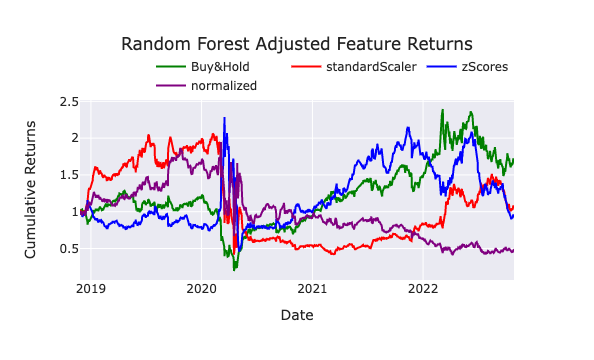

crudeOil_descriptiveStatistics


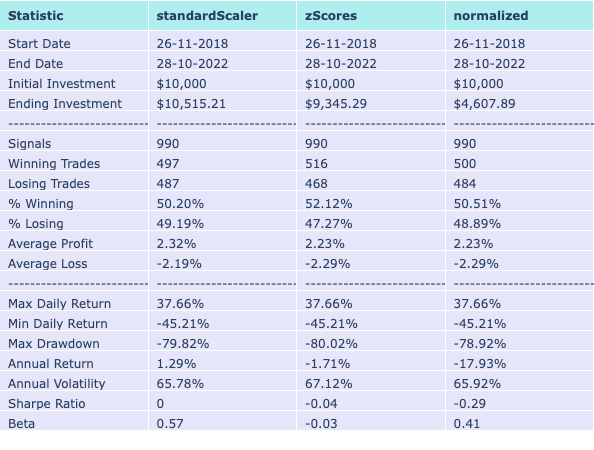

Gold
------------


Gold_RFadjustedFeatureReturns


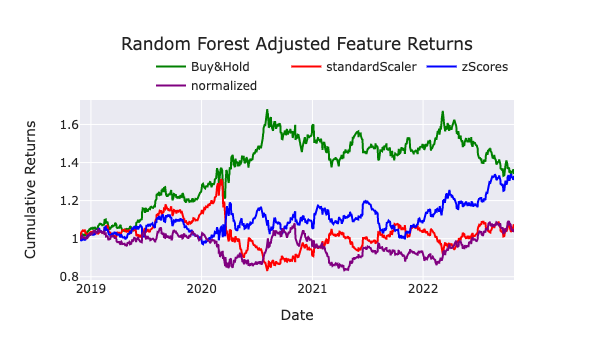

Gold_descriptiveStatistics


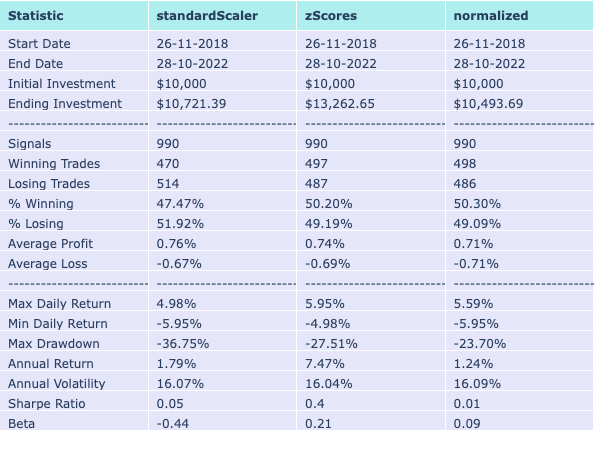

Russel2000
------------


Russel2000_RFadjustedFeatureReturns


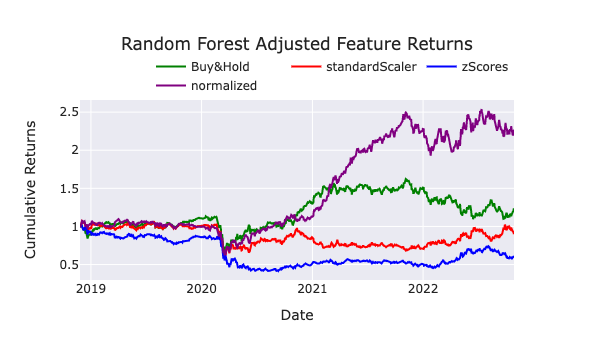

Russel2000_descriptiveStatistics


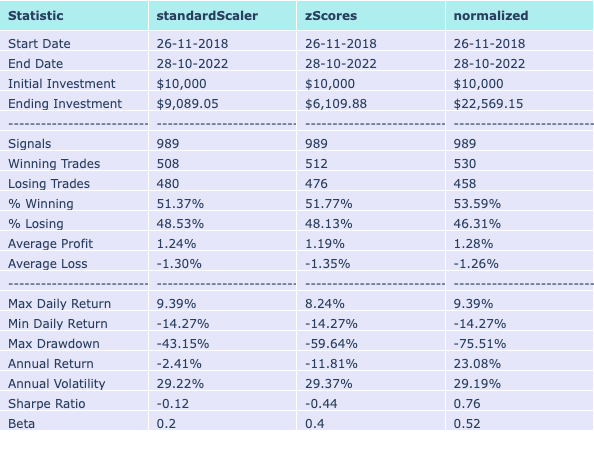

S&P500
------------


S&P500_RFadjustedFeatureReturns


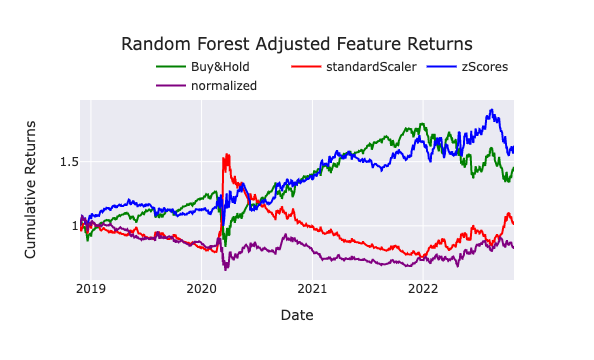

S&P500_descriptiveStatistics


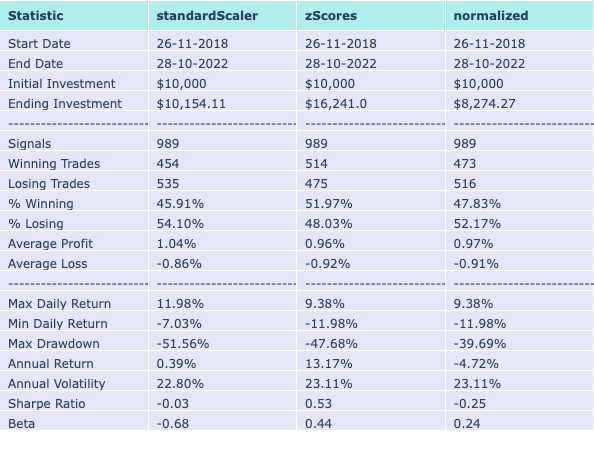

EUR-USD
------------


EUR-USD_RFadjustedFeatureReturns


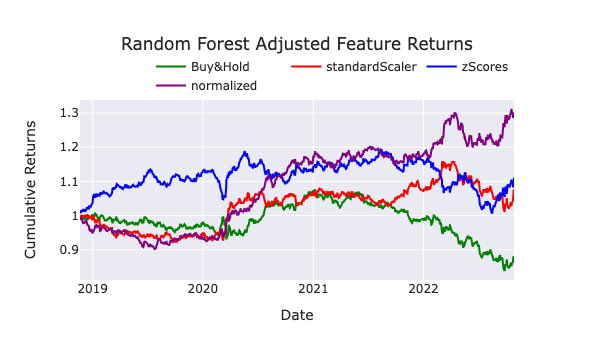

EUR-USD_descriptiveStatistics


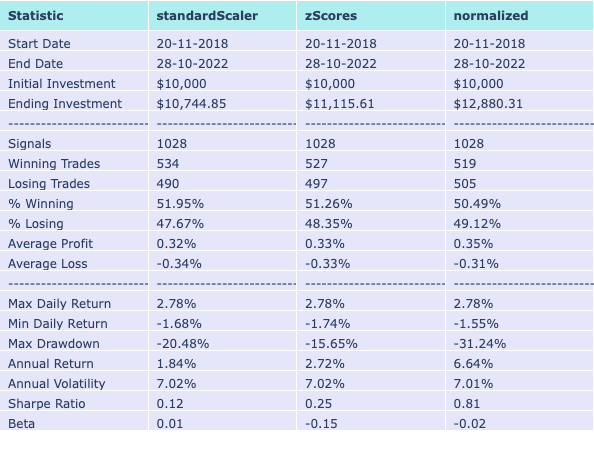

GBP-JPY
------------


GBP-JPY_RFadjustedFeatureReturns


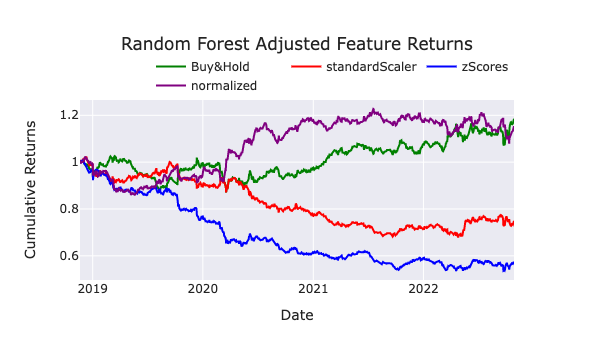

GBP-JPY_descriptiveStatistics


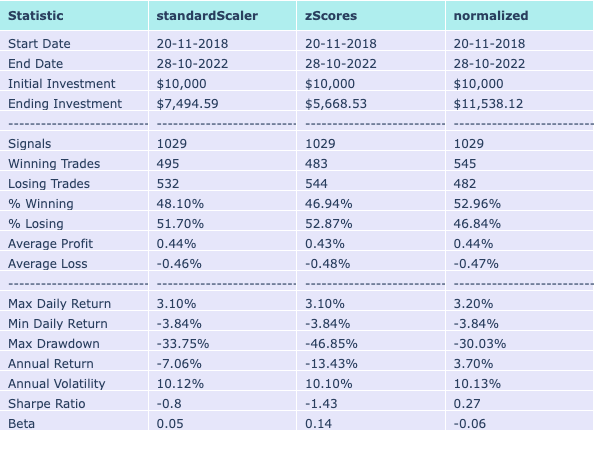

BTC-USD
------------


BTC-USD_RFadjustedFeatureReturns


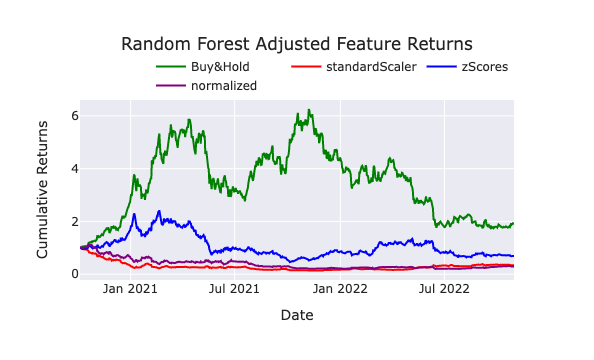

BTC-USD_descriptiveStatistics


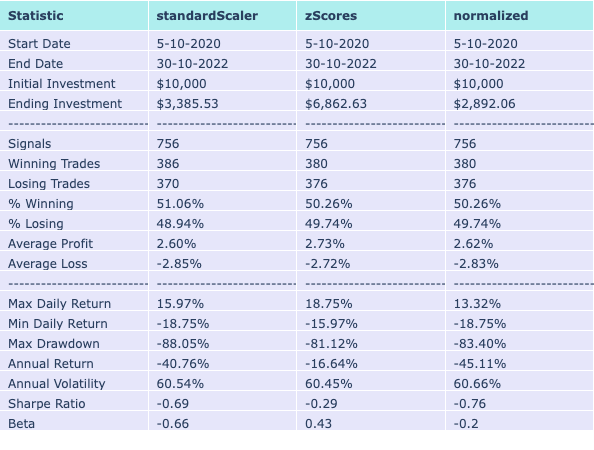

ETH-USD
------------


ETH-USD_RFadjustedFeatureReturns


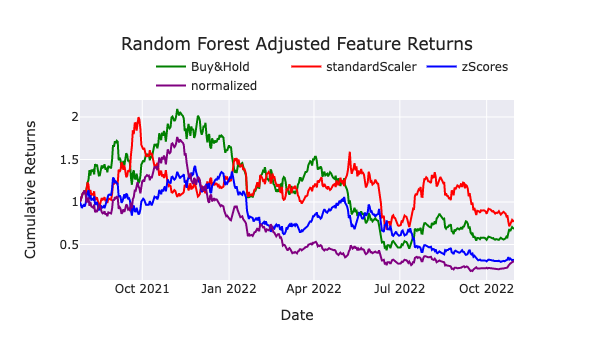

ETH-USD_descriptiveStatistics


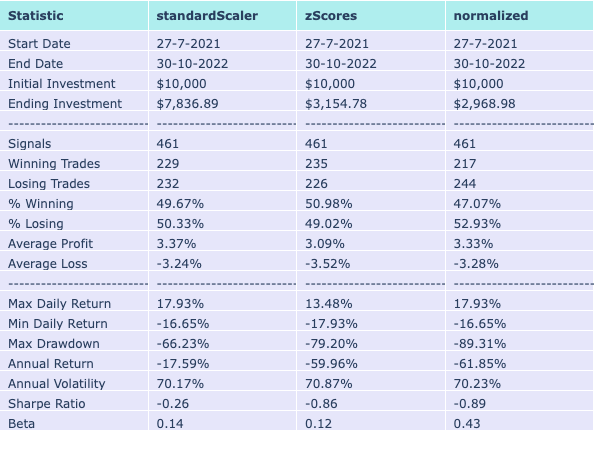

In [8]:
assetCount = len(assetNames)

#featureCount = len(featureList)


for i in range(0, assetCount):
    
    # Loading data

    file_name = "../Datasets/algoData_"+assetNames[i]+".csv"
    file_path = Path(file_name)
    df = pd.read_csv(file_path)
    df.set_index('Date', inplace=True)
    df.index = pd.to_datetime(df.index)
    
    # Set training months
    if(assetNames[i] == 'ETH-USD'):
        training_months = 42
    elif(assetNames[i] == 'BTC-USD'):
        training_months = 70
    else:
        training_months = 145
    
    rfModelScores = []
    rfModelPerformance = []
    cumStrategyReturns = []
    
    for var in range(0,3):
        
        # Separate the y variable and the features
        y = df['Signal'].copy()
        X = df[featureList[var]]
        
        # Split data into training and test sets
        
        training_begin = X.index.min()
        training_end = X.index.min() + DateOffset(months=training_months)
        
        # Generate the X_train and y_train DataFrames
        X_train = X.loc[training_begin:training_end]
        y_train = y.loc[training_begin:training_end]
        
        # Generate the X_test and y_test DataFrames
        X_test = X.loc[training_end+DateOffset(days=1):]
        y_test = y.loc[training_end+DateOffset(days=1):]

        ind = X_test.index
        
        if(var == 0):
    
            # Create a StandardScaler instance
            scaler = StandardScaler()
 
            # Apply the scaler model to fit the X-train data
            X_scaler = scaler.fit(X_train)

            X_train = X_scaler.transform(X_train)
            X_test = X_scaler.transform(X_test)
            
        # Create the random forest classifier instance
        rf_model = RandomForestClassifier(n_estimators=estimators, random_state=42)
    
        # Fit the model
        rf_model = rf_model.fit(X_train, y_train)
        
        # Making predictions using the testing data
        predictions = rf_model.predict(X_test)
        
        
        if(var == 0):
            model = 'standardScaler'
        elif(var==1):
            model = 'zScores'
        else:
            model = 'normalized'
        
        
        report = classification_report(y_test, predictions, output_dict=True)
        #rfMetrics = pd.DataFrame(report).transpose()
        rfMetrics = pd.DataFrame(report).transpose()
        rfMetrics['model'] = model 
        rfMetrics['scores'] = rfMetrics.index
        rfMetrics = rfMetrics.reset_index()
        
        rfModelScores.append(rfMetrics)
        
        # Create a predictions DataFrame
        predictions_df = pd.DataFrame(index=ind)

        # Add the RF model predictions to the DataFrame
        predictions_df['Predicted'] = predictions

        predictions_df['ActualReturns'] = df['ActualReturns']
        predictions_df['cumActualReturns'] = (1 + predictions_df['ActualReturns']).cumprod()

        # Add the strategy returns to the DataFrame
        predictions_df['StrategyReturns'] = predictions_df['ActualReturns'] * predictions_df['Predicted']
        # Add cumulative strategy returns to the DataFrame
        predictions_df['cumStrategyReturns'] = (1 + predictions_df['StrategyReturns']).cumprod()
        
        cumStrategyReturns.append(predictions_df)
        
        stats = descriptiveStatistics(predictions_df,model)
        
        rfModelPerformance.append(stats)
        #del(stats)
        
    print(assetNames[i])
    print('------------')
    print('\n')
    
    # save rfScores
    rfScores = pd.concat(rfModelScores, axis=0)
    rfScores = rfScores.set_index(['model','scores'])
    rfScores = rfScores.drop(['index'], axis=1)
    #rfScores = rfScores.transpose()
    rfScores.to_csv('RFmodelScores_'+assetNames[i]+'.csv')
    
    # save cumulative strategy returns
    StrategyReturns = pd.concat(cumStrategyReturns, axis=1)
    StrategyReturns['AssetReturns'] = StrategyReturns.iloc[:,2]
    StrategyReturns['standardScaler'] = StrategyReturns.iloc[:,4]
    StrategyReturns['zScores'] = StrategyReturns.iloc[:,9]
    StrategyReturns['normalized'] = StrategyReturns.iloc[:,14]
    StrategyReturns = StrategyReturns.drop(['ActualReturns', 'cumActualReturns', 'cumStrategyReturns',
                                        'StrategyReturns', 'Predicted'], axis=1)
    
    print(assetNames[i]+'_RFadjustedFeatureReturns')
    cumulativeStrategyReturnsPlot(StrategyReturns, assetNames[i])
        
    # save rfModelPerformance
    rfModelPerf = pd.concat(rfModelPerformance, axis=1)   
    rfModelPerf.to_csv('RFstrategyResults_'+assetNames[i]+'.csv')
    print(assetNames[i]+'_descriptiveStatistics')
    descriptiveStats(rfModelPerf, assetNames[i])